# Purpose


**2023-04-07**: 
<br> here we'll test a simplified flow to get an ETA for how long it'll take to take subreddit-embeddings to get user-level embeddings.

We'll test pandas v. polars. The hope is that polars will boost parallel performance enough to make the embedding step feasible to run in less than one day. If we can run the embedding step fast enough, we might be able to cache the job daily so that we can keep the latest data ready to use for PN and for other models.

---



# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [108]:
from datetime import datetime
import logging
from logging import info
import os
from pathlib import Path
import json

import polars as pl
import numpy as np
import pandas as pd
import plotly
import seaborn as sns

from tqdm.auto import tqdm
import dask
import mlflow
import hydra

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook
from collections import Counter

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize  # if we normalize the data, euclidean distance is approx of cosine


print_lib_versions([hydra, np, pd, pl, plotly, sklearn, subclu])

python		v 3.7.10
===
hydra		v: 1.1.0
numpy		v: 1.19.5
pandas		v: 1.2.4
polars		v: 0.17.1
plotly		v: 5.11.0
sklearn		v: 0.24.1
subclu		v: 0.6.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Define custom functions

In [318]:
from typing import Any, Union


def reshape_tos_for_df(
    user_id: str,
    tos_str_dict: str,
    tos_col_name: str = 'tos_pct',
) -> list:
    """Take the nested dict in a df and reshape it so that we can get a long df
    where each row is a user+subreddit Time on Sub percentage
    """
    d_tos_in = json.loads(tos_str_dict)
    
    d_out = {
        'user_id': [user_id] * len(d_tos_in),
        'subreddit_id': list(),
        tos_col_name: list(),
    }
    
    for sub_id, tos_pc in d_tos_in.items():
        d_out['subreddit_id'].append(sub_id)
        d_out[tos_col_name].append(tos_pc)
    
    return d_out


def reshape_embeddings_for_df(
    subreddit_id: str,
    subreddit_name: str,
    embeddings: np.array,
    embedding_col_prefix: str = 'embedding',
) -> list:
    """
    Take the nested embedding data and convert it to a flat df so it's easy to manipulate & multiply
    """
    d_out = {
        'subreddit_id': subreddit_id,
        'subreddit_name': subreddit_name,
    }
    
    for i, emb_ in enumerate(embeddings):
        d_out[f"{embedding_col_prefix}{i:03,.0f}"] = emb_
    
    return d_out


def delayed_select_for_polars(
    pl_df: pl.LazyFrame,
    select_kwargs: Any,
) -> pl.DataFrame:
    """Use this function as a fix for polars.lazy() that breaks when selecting an unnested struct
    If we apply this function with dask.delayed() we can compute the long df_tos in 10 parallel jobs(!)
    
    dask -> compute()
    polars -> collect()
    """
    return (
        pl_df
        .collect()
        .select(
            select_kwargs
        )
    )
    

# Get data

## Get user IDs to embed with time-on-subreddit features

I'm caching the data in a view so that it's easier to re-use while testing.

The time-on-subreddit feature is already in gazette features so we don't need to waste time computing them.

```SQL
SELECT 
    DISTINCT user_id

FROM `data-prod-165221.fact_tables.post_consume_post_detail_view_events` 
WHERE DATE(pt) BETWEEN (CURRENT_DATE() - 7) AND (CURRENT_DATE() - 2)
    AND subreddit_name IN ('themandaloriantv')
    AND action IN ('consume', 'view')
-- LIMIT 1000
```

In [5]:
%%time
%%bigquery df_users_raw_tos --project data-science-prod-218515 

-- pull the user IDs and the time on sub, but do the calculations in python b/c 
--   it can be a pain to conver to rows in BQ

SELECT
    ui.user_id
    , t.* EXCEPT(user_id)
    -- , t.feature_value
    -- , t.json_val 
    -- , t.feature_name
FROM (
        SELECT
            entity_id AS user_id
            , feature_value
            -- , (SAFE.parse_json(feature_value)) AS json_val
        FROM `data-prod-165221.user_feature_platform.time_on_subreddit_pct_time_over_30_day_v1`

        WHERE DATE(pt) = CURRENT_DATE() - 3 -- Latest appears to be (Today-3) b/c of lag from other tables
    ) AS t
    INNER JOIN (
        SELECT *
        FROM `reddit-employee-datasets.david_bermejo.pn_test_users_for_embedding` 
        -- LIMIT 10
    ) AS ui
        ON ui.user_id = t.user_id
;

Downloading: 100%|██████████| 856423/856423 [00:10<00:00, 79436.67rows/s] 


CPU times: user 8.91 s, sys: 4.57 s, total: 13.5 s
Wall time: 35.7 s


In [6]:
df_users_raw_tos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856423 entries, 0 to 856422
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        856423 non-null  object
 1   feature_value  856423 non-null  object
dtypes: object(2)
memory usage: 13.1+ MB


In [7]:
df_users_raw_tos.head()

,user_id,feature_value
0,t2_8p8h0ki0b,"{""t5_3fn31"":0.87899,""t5_2qhsa"":0.00445,""t5_2tex6"":0.00187,""t5_2xcv7"":0.00351,""t5_dyqlw"":0.05844,""t5_2qh33"":0.00406,""t5_3boqz"":0.00117,""t5_2s7tt"":0.00421,""t5_3aegn"":0.0103,""t5_2r5rp"":0.00335,""t5_2w7mz"":0.00437,""t5_3fzm9"":0.00359,""t5_2xhv..."
1,t2_8p90xabzf,"{""t5_3phq9"":0.13502,""t5_2qh1i"":0.22281,""t5_23gidu"":0.04516,""t5_2vg7t"":0.04516,""t5_2w844"":0.01567,""t5_2qkhb"":0.01912,""t5_2yrq6"":0.02788,""t5_2qh0u"":0.18687,""t5_2rqcm8"":0.07166,""t5_3boqz"":0.02304,""t5_3gcwj"":0.07742,""t5_2si92"":0.10645,""t5_3..."
2,t2_8p81pzwi9,"{""t5_2wzm6"":0.0219,""t5_2cneq"":0.00365,""t5_2tex6"":0.01825,""t5_30tmh"":0.01095,""t5_386zh"":0.04866,""t5_2w844"":0.06813,""t5_2w7mz"":0.09611,""t5_2vegg"":0.0438,""t5_3mj3w"":0.04988,""t5_2r40o"":0.13504,""t5_3i3vm"":0.0365,""t5_2qhds"":0.04136,""t5_2qh72""..."
3,t2_8p90y,"{""t5_38y725"":0.00134,""t5_27xp1u"":2e-05,""t5_7m6f8m"":1e-05,""t5_2tdzg"":0.00057,""t5_2taso"":2e-05,""t5_2sokd"":0.02098,""t5_2rjz2"":0.00395,""t5_2s4pd"":0.01769,""t5_2qh61"":0.0028,""t5_2qimj"":2e-05,""t5_r1l2z"":6e-05,""t5_2s5ti"":0.00164,""t5_2xinb"":0.00..."
4,t2_8p853,"{""t5_2s6nz"":0.00038,""t5_2y1j5"":8e-05,""t5_4b0bzv"":0.0001,""t5_2va9w"":5e-05,""t5_35n7t"":0.05491,""t5_2z8fuj"":0.00109,""t5_2xp02"":0.00107,""t5_3chmw"":0.00012,""t5_2tk0s"":1e-05,""t5_3ptyd"":0.00131,""t5_mvcq5"":0.01587,""t5_2vxxc"":0.0004,""t5_2s28b"":0...."


## Get subreddit-level embeddings

In [253]:
%%time
%%bigquery df_sub_emb --project data-science-prod-218515 

-- This aggregation is a pain to unnest, but it's the best we have (can't trust UNNESTING in SQL becuse order is not guaranteed)
SELECT
  subreddit_id
  , subreddit_name
  , ARRAY_CONCAT(embedding) AS embedding  
FROM `data-prod-165221.ml_content.subreddit_embeddings_ft2`
WHERE DATE(pt) = '2023-04-04'

Downloading: 100%|██████████| 242345/242345 [00:02<00:00, 84134.32rows/s] 


CPU times: user 752 ms, sys: 411 ms, total: 1.16 s
Wall time: 16.2 s


In [254]:
df_sub_emb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242345 entries, 0 to 242344
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   subreddit_id    242345 non-null  object
 1   subreddit_name  242345 non-null  object
 2   embedding       242345 non-null  object
dtypes: object(3)
memory usage: 5.5+ MB


In [255]:
df_sub_emb.head()

,subreddit_id,subreddit_name,embedding
0,t5_2ebdae,fuckangryupvote,"[-0.45830655097961426, -0.1243768185377121, -0.456529825925827, -0.07116681337356567, -0.12949645519256592, 0.05023331567645073, -0.22352294623851776, 0.41953814029693604, 0.2228589951992035, 0.3291063606739044, 0.2328146994113922, -0.1..."
1,t5_7cp4il,fuckanik0,"[-0.7657153606414795, 0.048177484422922134, -0.464771568775177, -0.09490388631820679, 0.17050868272781372, -0.1313280165195465, -0.6086512804031372, 0.5065695643424988, -0.1678677648305893, 0.3177518844604492, -0.04505475237965584, -0.1..."
2,t5_74k0ix,fuckaroundxfindout,"[-0.3270401358604431, 0.06220916286110878, -0.3199388086795807, 0.2945059537887573, -0.12446127086877823, 0.09056004881858826, -0.4841662645339966, 0.2888942360877991, -0.08934880793094635, 0.5394051671028137, 0.5159727334976196, 0.1917..."
3,t5_80xbhl,fuckatlastelamon24,"[-0.17828771471977234, 0.08107554167509079, -0.4100566506385803, -0.12772995233535767, 0.03353101387619972, 0.1698012501001358, -0.11168640851974487, 0.4089040160179138, 0.3309285640716553, 0.3384820818901062, 0.29350802302360535, -0.15..."
4,t5_28w67l,fuckbabyyoda,"[-0.041489940136671066, 0.0769181177020073, -0.3346327245235443, 0.1930127888917923, -0.20167650282382965, 0.389017790555954, -0.2963216006755829, 0.42427146434783936, 0.2874469757080078, 0.8162460327148438, 0.05606146901845932, -0.1494..."


In [261]:
df_sub_emb['subreddit_name'].head().str.len()

0    15
1     9
2    18
3    18
4    12
Name: subreddit_name, dtype: int64

In [303]:
# df_sub_emb['embedding'].head().values

In [265]:
df_sub_emb.columns

Index(['subreddit_id', 'subreddit_name', 'embedding'], dtype='object')

In [299]:
np.array(['subreddit_name', 'subreddit_id'])

array(['subreddit_name', 'subreddit_id'], dtype='<U14')

In [317]:
n_emb_cols = df_sub_emb['embedding'].iloc[0].shape[0]
assert np.alltrue(n_emb_cols == df_sub_emb['embedding'].str.len())


l_emb_cols = [f"{embedding_col_prefix}{i:03,.0f}" for i in range(n_emb_cols)]
print(len(l_emb_cols))


100


# Transform - sub embeddings to wide

In [335]:
%%time

# pandas is slow and it's not worth creating custom function
# df_sub_emb_wide = pd.concat(
#     [pd.DataFrame(_) for _ in (
#         df_sub_emb
#         .head(5000)
#         .apply(
#             lambda x: list(
#                 reshape_embeddings_for_df(
#                     subreddit_name=x['subreddit_name'],
#                     subreddit_id=x['subreddit_id'],
#                     embeddings=x['embedding'],
#                     embedding_col_prefix=embedding_col_prefix,
#                 )
#             ),
#             axis='columns'
#         )
#         .to_list()
#     )
#     ],
#     ignore_index=True,
# )
# print(df_sub_emb_wide.shape)
# df_sub_emb_wide.head()

(510000, 1)
CPU times: user 1.54 s, sys: 7.03 ms, total: 1.55 s
Wall time: 1.55 s


,0
0,subreddit_id
1,subreddit_name
2,embedding_000
3,embedding_001
4,embedding_002


In [336]:
df_sub_emb_wide.tail()

,0
509995,embedding_095
509996,embedding_096
509997,embedding_097
509998,embedding_098
509999,embedding_099


In [330]:
%%time
embedding_col_prefix = 'embedding_'

dfp_sub_emb_wide = (
    pl.DataFrame(df_sub_emb)
    .select(
        pl.struct(['subreddit_id', 'subreddit_name', 'embedding'])
        .apply(
            lambda x: reshape_embeddings_for_df(
                subreddit_name=x['subreddit_name'],
                subreddit_id=x['subreddit_id'],
                embeddings=x['embedding'],
                embedding_col_prefix=embedding_col_prefix,
            )
        )
        .alias('subreddit_emb_expanded')
    )
    ['subreddit_emb_expanded']
    .struct.unnest()
)
    
dfp_sub_emb_wide = dfp_sub_emb_wide[reorder_array(['subreddit_name', 'subreddit_id'], dfp_sub_emb_wide.columns)]

l_emb_cols = [c_ for c_ in dfp_sub_emb_wide.columns if c_.startswith(embedding_col_prefix)]
print(len(l_emb_cols))

print(dfp_sub_emb_wide.shape)

100
(242345, 102)
CPU times: user 28.6 s, sys: 3.58 s, total: 32.2 s
Wall time: 31.5 s


In [337]:
dfp_sub_emb_wide.head()

subreddit_name,subreddit_id,embedding_000,embedding_001,embedding_002,embedding_003,embedding_004,embedding_005,embedding_006,embedding_007,embedding_008,embedding_009,embedding_010,embedding_011,embedding_012,embedding_013,embedding_014,embedding_015,embedding_016,embedding_017,embedding_018,embedding_019,embedding_020,embedding_021,embedding_022,embedding_023,embedding_024,embedding_025,embedding_026,embedding_027,embedding_028,embedding_029,embedding_030,embedding_031,embedding_032,embedding_033,embedding_034,…,embedding_063,embedding_064,embedding_065,embedding_066,embedding_067,embedding_068,embedding_069,embedding_070,embedding_071,embedding_072,embedding_073,embedding_074,embedding_075,embedding_076,embedding_077,embedding_078,embedding_079,embedding_080,embedding_081,embedding_082,embedding_083,embedding_084,embedding_085,embedding_086,embedding_087,embedding_088,embedding_089,embedding_090,embedding_091,embedding_092,embedding_093,embedding_094,embedding_095,embedding_096,embedding_097,embedding_098,embedding_099
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""fuckangryupvot…","""t5_2ebdae""",-0.458307,-0.124377,-0.45653,-0.071167,-0.129496,0.050233,-0.223523,0.419538,0.222859,0.329106,0.232815,-0.132964,0.042578,-0.187635,0.032669,-0.097246,0.248933,0.081803,0.01614,-0.059382,0.232044,-0.229108,-0.099697,0.112958,0.287998,0.143571,0.110912,-0.056861,-0.348287,0.042438,-0.163465,0.143917,-0.017838,-0.372755,0.156338,…,-0.047599,-0.009217,-0.398875,0.041359,0.169443,-0.292089,-0.06315,-0.688448,0.122539,0.701312,-0.033934,-0.126428,-0.021342,-0.058136,-0.160805,-0.233582,-0.11476,-0.207059,-0.19208,0.42188,0.12501,-0.441611,-0.209567,0.330297,-0.104124,-0.035538,0.001113,0.021887,0.220516,-0.125512,0.085734,-0.221911,0.019733,0.381804,0.106661,-0.054146,0.034587
"""fuckanik0""","""t5_7cp4il""",-0.765715,0.048177,-0.464772,-0.094904,0.170509,-0.131328,-0.608651,0.50657,-0.167868,0.317752,-0.045055,-0.190148,-0.072024,0.014071,0.343348,-0.744289,0.395009,0.072519,0.702949,0.743473,-0.111481,-0.593468,0.225758,0.180509,0.03334,0.57731,0.152853,-0.297522,-0.067208,0.140899,-0.009258,0.44042,0.415357,-0.240831,-0.302296,…,-0.110359,0.982417,-0.008637,0.777253,0.106275,-1.126837,-0.187583,-0.202971,0.040154,0.929265,0.227556,-0.164199,0.154003,-0.003316,-0.435552,-0.549721,-0.542573,-0.058687,-0.037692,0.232936,0.410203,-0.624834,-0.135485,-0.263023,-0.24021,-0.263799,-0.076655,-0.504038,-0.020553,0.247665,0.585173,-0.315736,-0.238108,0.176526,-0.056594,0.147414,0.217591
"""fuckaroundxfin…","""t5_74k0ix""",-0.32704,0.062209,-0.319939,0.294506,-0.124461,0.09056,-0.484166,0.288894,-0.089349,0.539405,0.515973,0.191757,0.081771,0.226133,-0.332329,-0.011259,0.25925,0.502889,0.240677,-0.678129,0.167942,-0.227761,0.27393,0.591853,-0.184245,0.063489,0.210365,-0.298517,0.028132,-0.028993,0.322376,0.080647,0.141867,-0.548325,0.74636,…,0.06916,0.804587,0.328748,0.364194,0.094847,-0.234976,0.189123,-1.034129,-0.197767,0.463933,0.755228,-0.348137,-0.054709,-0.41518,-0.060718,-0.092904,-0.347906,-0.568953,-0.413873,0.365812,0.077475,-0.532172,-0.850686,-0.100594,0.300156,-0.035989,-0.165565,-0.08324,-0.05425,-0.15632,0.179638,-0.195231,-0.202683,0.099378,-0.128004,-0.134303,0.024317
"""fuckatlastelam…","""t5_80xbhl""",-0.178288,0.081076,-0.410057,-0.12773,0.033531,0.169801,-0.111686,0.408904,0.330929,0.338482,0.293508,-0.156262,0.060648,-0.354247,0.102031,-0.178883,0.113465,0.156083,0.289543,-0.021504,0.041469,-0.114685,-0.149023,0.129301,0.238067,0.154112,-0.026729,-0.236533,-0.191923,-0.271482,0.257562,0.144543,0.058647,0.082037,0.255612,…,-0.28246,0.262651,-0.021765,0.296327,-0.013709,-0.358452,-0.165951,-0.338177,0.335548,-0.057391,0.218258,-0.556176,0.305899,0.044577,-0.140355,0.039219

# Transform - Count of subreddits per user


In [11]:
%%time

dfp_users_tos = pl.DataFrame(df_users_raw_tos)

CPU times: user 1.09 s, sys: 842 ms, total: 1.93 s
Wall time: 1.89 s


In [12]:
%%time

df_users_tos = df_users_raw_tos.copy()

CPU times: user 28.2 ms, sys: 7.95 ms, total: 36.1 ms
Wall time: 35.5 ms


## Pandas
Reshape user data to get:
- count the number of subreddits for each user



In [19]:
%%time

df_users_tos['subreddit_count'] = (
    df_users_tos['feature_value'].apply(lambda x: len(json.loads(x)) )
)

CPU times: user 38.7 s, sys: 894 ms, total: 39.6 s
Wall time: 39.6 s


In [20]:
df_users_tos.describe()

,subreddit_count
count,856423.000000
mean,152.496149
std,141.629998
min,1.000000
25%,47.000000
50%,118.000000
75%,215.000000
max,2085.000000


## Polars

In [15]:
dfp_users_tos.describe()

describe,user_id,feature_value
str,str,str
"""count""","""856423""","""856423"""
"""null_count""","""0""","""0"""
"""mean""",null,null
"""std""",null,null
"""min""","""t2_10009m""","""{""t5_100kj8"":4…"
"""max""","""t2_zzzz9""","""{""t5_zzwxp"":0.…"
"""median""",null,null


In [21]:
%%time

dfp_users_tos = dfp_users_tos.with_columns(
    pl.col('feature_value').apply(lambda x: len(json.loads(x)) ).alias('subreddit_count')
)

CPU times: user 40 s, sys: 1.13 s, total: 41.1 s
Wall time: 41.1 s


In [22]:
dfp_users_tos.describe()

describe,user_id,feature_value,subreddit_count
str,str,str,f64
"""count""","""856423""","""856423""",856423.0
"""null_count""","""0""","""0""",0.0
"""mean""",null,null,152.496149
"""std""",null,null,141.629998
"""min""","""t2_10009m""","""{""t5_100kj8"":4…",1.0
"""max""","""t2_zzzz9""","""{""t5_zzwxp"":0.…",2085.0
"""median""",null,null,118.0


# Transform - get long form 
Each row = user+subreddit

## Example on a single user

In [24]:
# convert 1 user's row to a df where each row is user+subreddit time

df_users_tos[df_users_tos['user_id'] == 't2_8fe238nke']['feature_value']

632536    {"t5_3nxko":0.02033,"t5_2r40o":0.02439,"t5_2t7no":0.00813,"t5_2thzw":0.01626,"t5_2qvp9":0.04472,"t5_2yrq6":0.03252,"t5_45hae8":0.01626,"t5_3ajbp":0.11382,"t5_2qi58":0.03659,"t5_2qhpn":0.04878,"t5_34a0h":0.49187,"t5_35mye":0.03252,"t5_2t...
Name: feature_value, dtype: object

In [25]:
# reshape_tos_for_df(
#     't2_8fe238nke',
#     df_users_tos[df_users_tos['user_id'] == 't2_8fe238nke']['feature_value'].values[0],
# )

pd.DataFrame(reshape_tos_for_df(
    't2_8fe238nke',
    df_users_tos[df_users_tos['user_id'] == 't2_8fe238nke']['feature_value'].values[0],
))

,user_id,subreddit_id,tos_pct
0,t2_8fe238nke,t5_3nxko,0.02033
1,t2_8fe238nke,t5_2r40o,0.02439
2,t2_8fe238nke,t5_2t7no,0.00813
3,t2_8fe238nke,t5_2thzw,0.01626
4,t2_8fe238nke,t5_2qvp9,0.04472
5,t2_8fe238nke,t5_2yrq6,0.03252
6,t2_8fe238nke,t5_45hae8,0.01626
7,t2_8fe238nke,t5_3ajbp,0.11382
8,t2_8fe238nke,t5_2qi58,0.03659
9,t2_8fe238nke,t5_2qhpn,0.04878


## Time estimates on just converting the data to the right format

with 10k users, Pandas seems WAY faster in this step:

```bash
# Pandas
803 ms ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Polars
2,020 ms s ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

##  2.02 s ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

In [28]:
%%timeit
(
    df_users_tos.head(int(1e4)).apply(lambda x: reshape_tos_for_df(x['user_id'], x['feature_value']), axis='columns')
)

803 ms ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit

(
    dfp_users_tos.head(int(1e4)).select(
        pl.struct(['user_id', 'feature_value']).apply(
            lambda x: reshape_tos_for_df(x['user_id'], x['feature_value'])
        ).alias('subreddit_tos_expanded')
    )
)

2.02 s ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Time estimates on converting the data to long df (on a sample of users)

We need to take into account the full time to convert to the output df

And we also compare the output of the two methods to check each other's outputm

In [49]:
n_long_test = int(5e4)
n_long_test

50000

In [51]:
%%time

# create a chain, instead of keeping a tmp df
dfp_users_tos_long_test = (
    dfp_users_tos.head(n_long_test).select(
        pl.struct(['user_id', 'feature_value'])
        .apply(
            lambda x: reshape_tos_for_df(x['user_id'], x['feature_value'])
        )
        .alias('subreddit_tos_expanded')
    )
    ['subreddit_tos_expanded'].struct.unnest().select(
        [
            pl.col('user_id').arr.explode(),
            pl.col('subreddit_id').arr.explode(),
            pl.col('tos_pct').arr.explode(),
        ]
    )
)
print(dfp_users_tos_long_test.shape)

(7054807, 3)
CPU times: user 11.5 s, sys: 1.46 s, total: 12.9 s
Wall time: 12.6 s


In [64]:
%%time

df_users_tos_long_test = pd.concat(
    [pd.DataFrame(_) for _ in
        (
            df_users_tos.head(n_long_test).apply(lambda x: reshape_tos_for_df(x['user_id'], x['feature_value']), axis='columns')
        ).to_list()
    ],
    ignore_index=True,
)
print(df_users_tos_long_test.shape)

(7054807, 3)
CPU times: user 37.9 s, sys: 1.01 s, total: 38.9 s
Wall time: 38.6 s


In [53]:
38.5 / 12.6

3.055555555555556

### Make sure that the df outputs are the same!

Note that we need to reset & drop the index for the pandas df because it keeps the index for each individual df unless we ignore index at concat time.

_NOTE_: When we use pd.equals() it also check the dataframe's index.

In [76]:
%%time

pa_eq_pl = dfp_users_tos_long_test.to_pandas().equals(df_users_tos_long_test.reset_index(drop=True))
print(pa_eq_pl)
assert pa_eq_pl
del pa_eq_pl

True
CPU times: user 1.71 s, sys: 104 ms, total: 1.81 s
Wall time: 1.79 s


In [72]:
np.array_equal(dfp_users_tos_long_test.to_pandas().index, df_users_tos_long_test.index)

True

In [77]:
shape_pol_test_ = dfp_users_tos_long_test.to_pandas().shape
shape_pan_test_ = df_users_tos_long_test.shape
print(shape_pol_test_)
print(shape_pan_test_)
print(shape_pan_test_ == shape_pol_test_)
del shape_pol_test_, shape_pan_test_

(7054807, 3)
(7054807, 3)
True


### Run timeit on test data [optional]
Don't really need to run time it because it's clear that polars is ~3x faster when we measure end-to-end result for final output (df_long)

In [54]:
# %%timeit

# df_users_tos_long_test = pd.concat(
#     [pd.DataFrame(_) for _ in 
#         (
#             df_users_tos.head(n_long_test).apply(lambda x: reshape_tos_for_df(x['user_id'], x['feature_value']), axis='columns')
#         ).to_list()
#     ]
# )

In [55]:
# %%timeit

# dfp_users_tos_long_test = (
#     dfp_users_tos.head(n_long_test).select(
#         pl.struct(['user_id', 'feature_value'])
#         .apply(
#             lambda x: reshape_tos_for_df(x['user_id'], x['feature_value'])
#         )
#         .alias('subreddit_tos_expanded')
#     )
#     ['subreddit_tos_expanded'].struct.unnest().select(
#         [
#             pl.col('user_id').arr.explode(),
#             pl.col('subreddit_id').arr.explode(),
#             pl.col('tos_pct').arr.explode(),
#         ]
#     )
# )

## Convert full data
with pandas, we have a lot of overhead so the whole process takes 13+ minutes (creating individual dataframes & then concat into a final df)

```bash
# Pandas
CPU times: user 12min 39s, sys: 1min 12s, total: 13min 51s
Wall time: 13min 46s


# Polars
CPU times: user 3min 49s, sys: 40.4 s, total: 4min 30s
Wall time: 4min 25s
```

In [81]:
(13 + 46/60) / (4 + 25/60)

3.116981132075472

In [78]:
%%time

# create a chain, instead of keeping a tmp df
dfp_users_tos_long_single = (
    dfp_users_tos
    .select(
        pl.struct(['user_id', 'feature_value'])
        .apply(
            lambda x: reshape_tos_for_df(x['user_id'], x['feature_value'])
        )
        .alias('subreddit_tos_expanded')
    )
    ['subreddit_tos_expanded'].struct.unnest()
    .select(
        [
            pl.col('user_id').arr.explode(),
            pl.col('subreddit_id').arr.explode(),
            pl.col('tos_pct').arr.explode(),
        ]
    )
)
print(dfp_users_tos_long_single.shape)

(130601209, 3)
CPU times: user 3min 49s, sys: 40.4 s, total: 4min 30s
Wall time: 4min 25s


In [69]:
# %%time

# df_tos_long = pd.concat(
#     [pd.DataFrame(_) for _ in 
#         (
#             df_users_tos.apply(lambda x: reshape_tos_for_df(x['user_id'], x['feature_value']), axis='columns')
#         ).to_list()
#     ]
# )
# print(df_tos_long)

CPU times: user 12min 39s, sys: 1min 12s, total: 13min 51s
Wall time: 13min 46s


### Can we speed it up even more by running a few calculations explicitly in parallel?

Hypothesis: <br>
with `dask.delayed()` we should be able to queue and run a few jobs in parallel which _should_ speed up the `polars` calculation even more

--- 

Actual findings:<br> 
No you can't improve when data is already in-memory [docs: https://pola-rs.github.io/polars-book/user-guide/howcani/multiprocessing.html].
dask.delayed() is slower than pure `polars`! This is kind of shocking but maybe the dask overhead is actually too slow v. the `rust` parallelization that `polars` is doing.

`dask` might still help if the workflow stars with reading `parquet` files and processing them in parallel (where each file is read and processed and saved in parallel).

03:41:51 | INFO | "Create DAG to calculate user<>subreddit long df in parallel..."


10


  0%|          | 0/10 [00:00<?, ?it/s]

03:41:51 | INFO | "Define df_tos_long DAG in dask"
03:41:51 | INFO | "Dask visualize DAG"


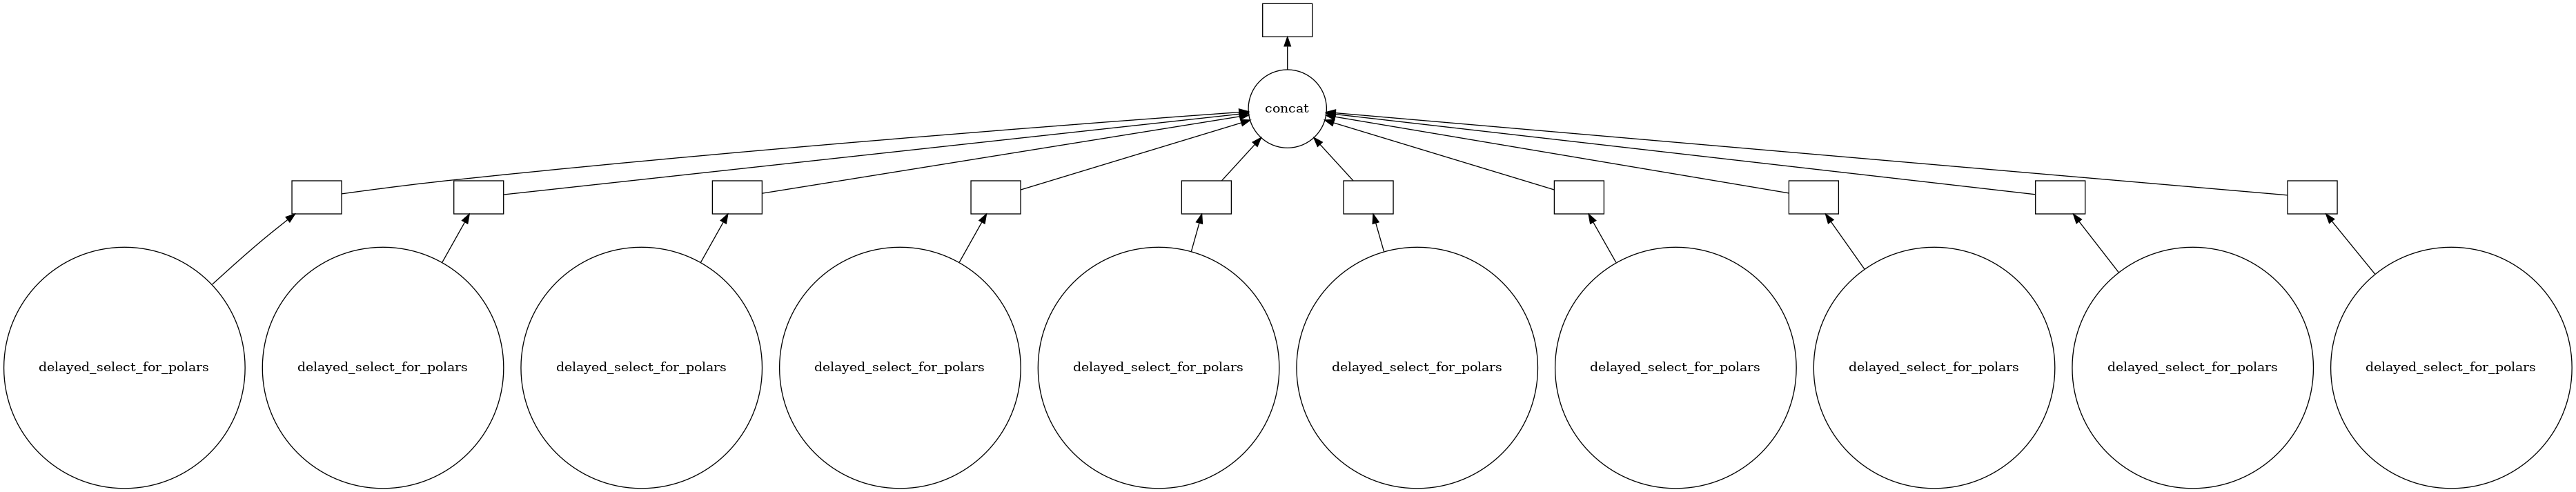

03:41:52 | INFO | "COMPUTE df_tos_long START"
03:46:46 | INFO | "COMPUTE df_tos_long DONE"


CPU times: user 4min 28s, sys: 41.1 s, total: 5min 9s
Wall time: 4min 55s


In [180]:
%%time

n_parallel_splits = 10

a_user_splits = np.array_split(df_users_raw_tos['user_id'], n_parallel_splits)
print(len(a_user_splits))

l_df_long_parallel = list()

info(f"Create DAG to calculate user<>subreddit long df in parallel...")
for users_ in tqdm(a_user_splits):
    # info(f"Define lazy df...")
    lazy_df = (
        dfp_users_tos
        .lazy()
        .filter(dfp_users_tos['user_id'].is_in(users_))
        # .head(10000)
        .select(
            pl.struct(['user_id', 'feature_value'])
            .apply(
                lambda x: reshape_tos_for_df(x['user_id'], x['feature_value'])
            )
            .alias('subreddit_tos_expanded')
        )
        .unnest('subreddit_tos_expanded')
    )
    # info(f"Append df with delayed explode with Dask")
    l_df_long_parallel.append(
        dask.delayed(delayed_select_for_polars)( 
            lazy_df,
            [
                pl.col('user_id').arr.explode(),
                pl.col('subreddit_id').arr.explode(),
                pl.col('tos_pct').arr.explode(),
            ]
        )
    )

info(f"Define df_tos_long DAG in dask")
dfp_users_tos_long_delayed = dask.delayed(pl.concat)(l_df_long_parallel, how='vertical', parallel=True)

info(f"Dask visualize DAG")
display(dfp_users_tos_long_delayed.visualize())

info(f"COMPUTE df_tos_long START")
dfp_users_tos_long = dfp_users_tos_long_delayed.compute()
info(f"COMPUTE df_tos_long DONE")

03:46:47 | INFO | "Create DAG to calculate user<>subreddit long df in parallel..."


4


  0%|          | 0/4 [00:00<?, ?it/s]

03:46:47 | INFO | "Define df_tos_long DAG in dask"
03:46:47 | INFO | "Dask visualize DAG"


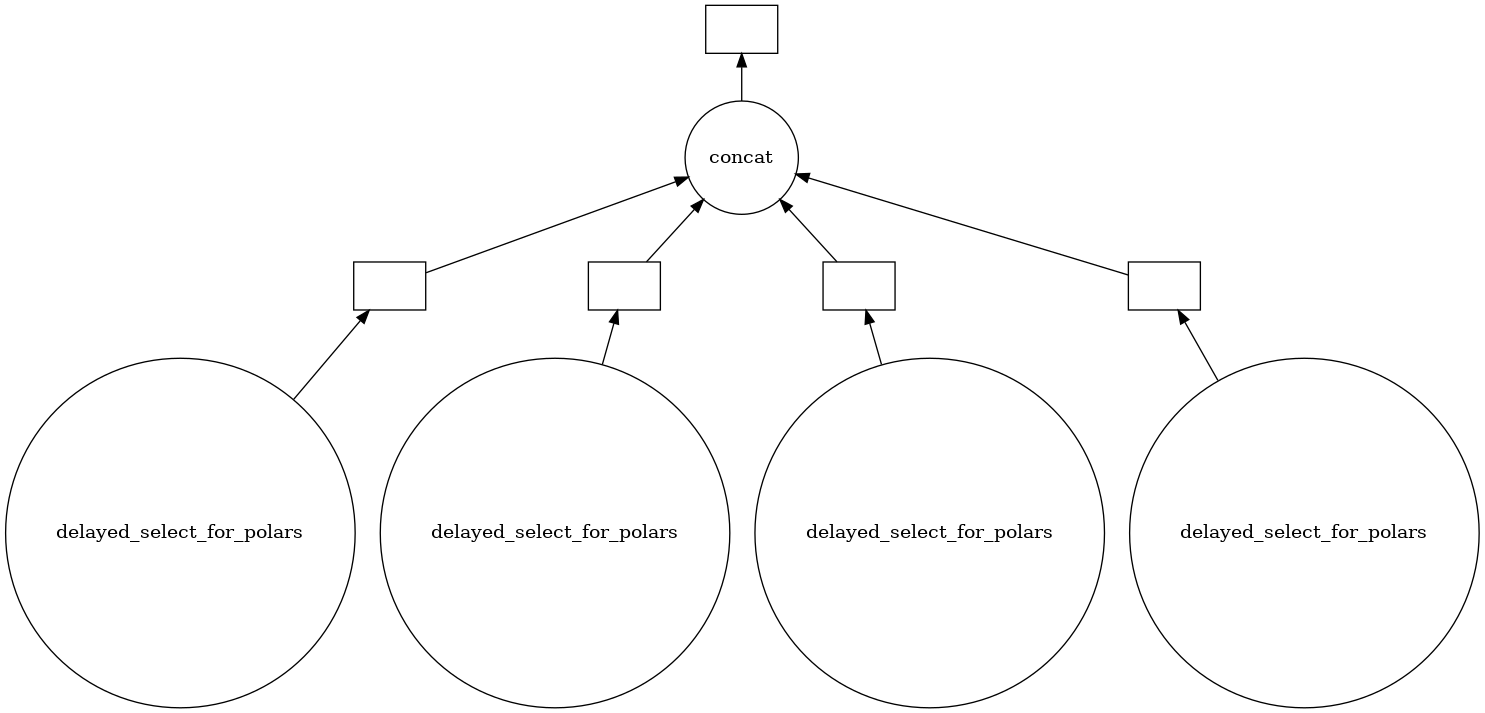

03:46:47 | INFO | "COMPUTE df_tos_long START"
03:52:19 | INFO | "COMPUTE df_tos_long DONE"


CPU times: user 4min 54s, sys: 50.5 s, total: 5min 45s
Wall time: 5min 33s


In [181]:
%%time

n_parallel_splits = 4

a_user_splits = np.array_split(df_users_raw_tos['user_id'], n_parallel_splits)
print(len(a_user_splits))

l_df_long_parallel = list()

info(f"Create DAG to calculate user<>subreddit long df in parallel...")
for users_ in tqdm(a_user_splits):
    # info(f"Define lazy df...")
    lazy_df = (
        dfp_users_tos
        .lazy()
        .filter(dfp_users_tos['user_id'].is_in(users_))
        # .head(10000)
        .select(
            pl.struct(['user_id', 'feature_value'])
            .apply(
                lambda x: reshape_tos_for_df(x['user_id'], x['feature_value'])
            )
            .alias('subreddit_tos_expanded')
        )
        .unnest('subreddit_tos_expanded')
    )
    # info(f"Append df with delayed explode with Dask")
    l_df_long_parallel.append(
        dask.delayed(delayed_select_for_polars)( 
            lazy_df,
            [
                pl.col('user_id').arr.explode(),
                pl.col('subreddit_id').arr.explode(),
                pl.col('tos_pct').arr.explode(),
            ]
        )
    )

info(f"Define df_tos_long DAG in dask")
dfp_users_tos_long_delayed = dask.delayed(pl.concat)(l_df_long_parallel, how='vertical', parallel=True)

info(f"Dask visualize DAG")
display(dfp_users_tos_long_delayed.visualize())

info(f"COMPUTE df_tos_long START")
dfp_users_tos_long = dfp_users_tos_long_delayed.compute()
info(f"COMPUTE df_tos_long DONE")

03:52:20 | INFO | "Create DAG to calculate user<>subreddit long df in parallel..."


2


  0%|          | 0/2 [00:00<?, ?it/s]

03:52:20 | INFO | "Define df_tos_long DAG in dask"
03:52:20 | INFO | "Dask visualize DAG"


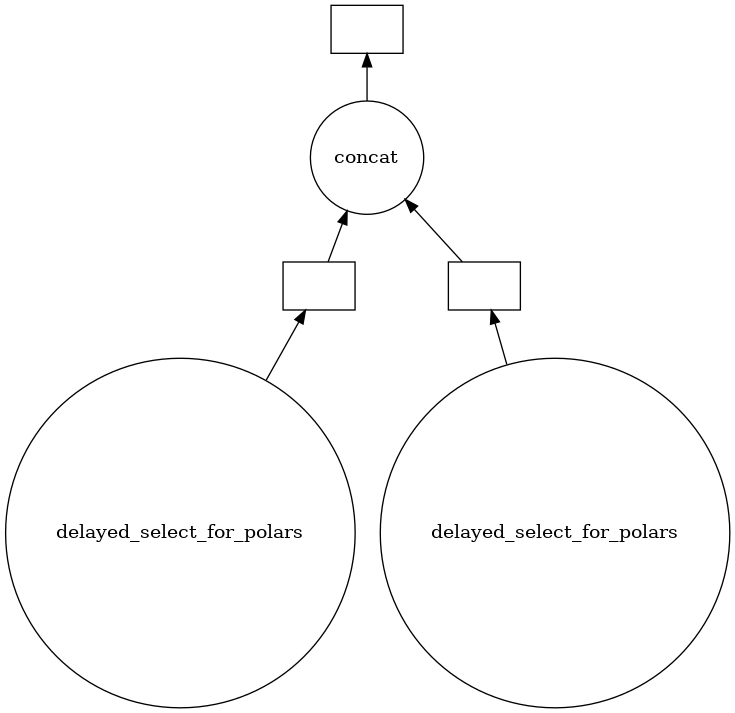

03:52:21 | INFO | "COMPUTE df_tos_long START"
03:57:55 | INFO | "COMPUTE df_tos_long DONE"


CPU times: user 4min 49s, sys: 53.8 s, total: 5min 43s
Wall time: 5min 35s


In [182]:
%%time

n_parallel_splits = 2

a_user_splits = np.array_split(df_users_raw_tos['user_id'], n_parallel_splits)
print(len(a_user_splits))

l_df_long_parallel = list()

info(f"Create DAG to calculate user<>subreddit long df in parallel...")
for users_ in tqdm(a_user_splits):
    # info(f"Define lazy df...")
    lazy_df = (
        dfp_users_tos
        .lazy()
        .filter(dfp_users_tos['user_id'].is_in(users_))
        # .head(10000)
        .select(
            pl.struct(['user_id', 'feature_value'])
            .apply(
                lambda x: reshape_tos_for_df(x['user_id'], x['feature_value'])
            )
            .alias('subreddit_tos_expanded')
        )
        .unnest('subreddit_tos_expanded')
    )
    # info(f"Append df with delayed explode with Dask")
    l_df_long_parallel.append(
        dask.delayed(delayed_select_for_polars)( 
            lazy_df,
            [
                pl.col('user_id').arr.explode(),
                pl.col('subreddit_id').arr.explode(),
                pl.col('tos_pct').arr.explode(),
            ]
        )
    )

info(f"Define df_tos_long DAG in dask")
dfp_users_tos_long_delayed = dask.delayed(pl.concat)(l_df_long_parallel, how='vertical', parallel=True)

info(f"Dask visualize DAG")
display(dfp_users_tos_long_delayed.visualize())

info(f"COMPUTE df_tos_long START")
dfp_users_tos_long = dfp_users_tos_long_delayed.compute()
info(f"COMPUTE df_tos_long DONE")

# Compute user-level weighted embedding

now that we have the long df, let's compute the user-level weighted embedding (multiply weights x embedding & groupby user-id)

In [338]:
%%time

print(dfp_sub_emb_wide.shape)
dfp_sub_emb_wide.head()

(242345, 102)
CPU times: user 546 µs, sys: 74 µs, total: 620 µs
Wall time: 499 µs


subreddit_name,subreddit_id,embedding_000,embedding_001,embedding_002,embedding_003,embedding_004,embedding_005,embedding_006,embedding_007,embedding_008,embedding_009,embedding_010,embedding_011,embedding_012,embedding_013,embedding_014,embedding_015,embedding_016,embedding_017,embedding_018,embedding_019,embedding_020,embedding_021,embedding_022,embedding_023,embedding_024,embedding_025,embedding_026,embedding_027,embedding_028,embedding_029,embedding_030,embedding_031,embedding_032,embedding_033,embedding_034,…,embedding_063,embedding_064,embedding_065,embedding_066,embedding_067,embedding_068,embedding_069,embedding_070,embedding_071,embedding_072,embedding_073,embedding_074,embedding_075,embedding_076,embedding_077,embedding_078,embedding_079,embedding_080,embedding_081,embedding_082,embedding_083,embedding_084,embedding_085,embedding_086,embedding_087,embedding_088,embedding_089,embedding_090,embedding_091,embedding_092,embedding_093,embedding_094,embedding_095,embedding_096,embedding_097,embedding_098,embedding_099
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""fuckangryupvot…","""t5_2ebdae""",-0.458307,-0.124377,-0.45653,-0.071167,-0.129496,0.050233,-0.223523,0.419538,0.222859,0.329106,0.232815,-0.132964,0.042578,-0.187635,0.032669,-0.097246,0.248933,0.081803,0.01614,-0.059382,0.232044,-0.229108,-0.099697,0.112958,0.287998,0.143571,0.110912,-0.056861,-0.348287,0.042438,-0.163465,0.143917,-0.017838,-0.372755,0.156338,…,-0.047599,-0.009217,-0.398875,0.041359,0.169443,-0.292089,-0.06315,-0.688448,0.122539,0.701312,-0.033934,-0.126428,-0.021342,-0.058136,-0.160805,-0.233582,-0.11476,-0.207059,-0.19208,0.42188,0.12501,-0.441611,-0.209567,0.330297,-0.104124,-0.035538,0.001113,0.021887,0.220516,-0.125512,0.085734,-0.221911,0.019733,0.381804,0.106661,-0.054146,0.034587
"""fuckanik0""","""t5_7cp4il""",-0.765715,0.048177,-0.464772,-0.094904,0.170509,-0.131328,-0.608651,0.50657,-0.167868,0.317752,-0.045055,-0.190148,-0.072024,0.014071,0.343348,-0.744289,0.395009,0.072519,0.702949,0.743473,-0.111481,-0.593468,0.225758,0.180509,0.03334,0.57731,0.152853,-0.297522,-0.067208,0.140899,-0.009258,0.44042,0.415357,-0.240831,-0.302296,…,-0.110359,0.982417,-0.008637,0.777253,0.106275,-1.126837,-0.187583,-0.202971,0.040154,0.929265,0.227556,-0.164199,0.154003,-0.003316,-0.435552,-0.549721,-0.542573,-0.058687,-0.037692,0.232936,0.410203,-0.624834,-0.135485,-0.263023,-0.24021,-0.263799,-0.076655,-0.504038,-0.020553,0.247665,0.585173,-0.315736,-0.238108,0.176526,-0.056594,0.147414,0.217591
"""fuckaroundxfin…","""t5_74k0ix""",-0.32704,0.062209,-0.319939,0.294506,-0.124461,0.09056,-0.484166,0.288894,-0.089349,0.539405,0.515973,0.191757,0.081771,0.226133,-0.332329,-0.011259,0.25925,0.502889,0.240677,-0.678129,0.167942,-0.227761,0.27393,0.591853,-0.184245,0.063489,0.210365,-0.298517,0.028132,-0.028993,0.322376,0.080647,0.141867,-0.548325,0.74636,…,0.06916,0.804587,0.328748,0.364194,0.094847,-0.234976,0.189123,-1.034129,-0.197767,0.463933,0.755228,-0.348137,-0.054709,-0.41518,-0.060718,-0.092904,-0.347906,-0.568953,-0.413873,0.365812,0.077475,-0.532172,-0.850686,-0.100594,0.300156,-0.035989,-0.165565,-0.08324,-0.05425,-0.15632,0.179638,-0.195231,-0.202683,0.099378,-0.128004,-0.134303,0.024317
"""fuckatlastelam…","""t5_80xbhl""",-0.178288,0.081076,-0.410057,-0.12773,0.033531,0.169801,-0.111686,0.408904,0.330929,0.338482,0.293508,-0.156262,0.060648,-0.354247,0.102031,-0.178883,0.113465,0.156083,0.289543,-0.021504,0.041469,-0.114685,-0.149023,0.129301,0.238067,0.154112,-0.026729,-0.236533,-0.191923,-0.271482,0.257562,0.144543,0.058647,0.082037,0.255612,…,-0.28246,0.262651,-0.021765,0.296327,-0.013709,-0.358452,-0.165951,-0.338177,0.335548,-0.057391,0.218258,-0.556176,0.305899,0.044577,-0.140355,0.039219

## Test on a subset

In [192]:
sample_users = dfp_users_tos['user_id'].unique().sort()[:100]
sample_users.head()

user_id
str
"""t2_10009m"""
"""t2_1000hh"""
"""t2_1000ih"""
"""t2_1000iqhd"""
"""t2_1001as"""
"""t2_1001ds"""
"""t2_1001ea"""
"""t2_1001iini"""
"""t2_1001l095"""


In [393]:
%%time

info(f"Append subreddit embeddings to user ToS")
dfp_user_emb_tmp_test = (
    dfp_users_tos_long
    .filter(
        dfp_users_tos_long['user_id'].is_in(sample_users)
    )
    .join(
        dfp_sub_emb_wide.drop('subreddit_name'),
        how='left',
        on=['subreddit_id']
    )
)

info(f"Compute weighted avg embedding for user-level")
df_user_emb_tmp_test = pd.DataFrame(
    ((dfp_user_emb_tmp_test['tos_pct'].to_numpy()) * dfp_user_emb_tmp_test[l_emb_cols].to_numpy().T).T,
    index=pd.MultiIndex.from_frame(dfp_user_emb_tmp_test[['user_id', 'subreddit_id', 'tos_pct']].to_pandas()),
    columns=l_emb_cols,
)

print(df_user_emb_tmp_test.shape)

info(f"Compute AGGREGATED user-level embedding...")
dfp_user_emb_test = (
    pl.DataFrame(df_user_emb_tmp_test.dropna(how='any').reset_index())
    .groupby(
        ['user_id']
    )
    .agg(
        [
            pl.col(l_emb_cols).mean()
        ]
    )
)
print(dfp_user_emb_test.shape)

07:03:29 | INFO | "Append subreddit embeddings to user ToS"
07:03:31 | INFO | "Compute weighted avg embedding for user-level"
07:03:31 | INFO | "Compute AGGREGATED user-level embedding..."


(20683, 100)
(100, 101)
CPU times: user 4.34 s, sys: 204 ms, total: 4.54 s
Wall time: 2.36 s


In [391]:
df_user_emb_tmp_test.head().dropna(how='any').reset_index()

,user_id,subreddit_id,tos_pct,embedding_000,embedding_001,embedding_002,embedding_003,embedding_004,embedding_005,embedding_006,embedding_007,embedding_008,embedding_009,embedding_010,embedding_011,embedding_012,embedding_013,embedding_014,embedding_015,embedding_016,embedding_017,embedding_018,embedding_019,embedding_020,embedding_021,embedding_022,embedding_023,embedding_024,embedding_025,embedding_026,...,embedding_070,embedding_071,embedding_072,embedding_073,embedding_074,embedding_075,embedding_076,embedding_077,embedding_078,embedding_079,embedding_080,embedding_081,embedding_082,embedding_083,embedding_084,embedding_085,embedding_086,embedding_087,embedding_088,embedding_089,embedding_090,embedding_091,embedding_092,embedding_093,embedding_094,embedding_095,embedding_096,embedding_097,embedding_098,embedding_099
0,t2_1007zc,t5_74is2,0.00022,-0.000091,0.000026,0.000071,-0.000007,-6.560965e-05,0.000026,0.000003,0.000010,0.000040,0.000047,-5.361350e-05,-9.533796e-05,0.000089,0.000016,-0.000008,0.000013,0.000038,0.000055,-0.000082,0.000013,-3.510821e-05,-0.000038,0.000066,2.006880e-05,0.000080,-0.000010,0.000023,...,-7.341610e-05,-0.000017,0.000144,-0.000084,-9.232126e-05,-1.367724e-04,0.000103,-0.000065,-0.000065,-0.000061,-0.000038,-0.000050,0.000194,0.000079,-0.000086,-0.000024,-0.000019,-0.000161,-0.000067,-0.000024,-0.000026,0.000070,-0.000050,-9.114684e-07,-0.000063,0.000003,0.000119,0.000087,1.415436e-07,6.047911e-05
1,t2_1007zc,t5_2tugx,0.00415,-0.000500,-0.001063,-0.001482,0.000974,9.975503e-04,0.000941,-0.000395,0.000030,-0.000200,0.002109,-1.210279e-03,-1.948826e-04,0.000377,0.002199,0.000895,0.001248,-0.000901,0.000631,-0.000939,0.001325,7.893471e-04,0.002068,0.002938,1.538133e-04,0.001569,0.000670,-0.000084,...,-1.173005e-03,-0.000740,0.001624,-0.000778,-1.945731e-03,-8.235359e-04,-0.000533,-0.002327,-0.000132,-0.001407,0.001388,-0.000636,0.001915,-0.000525,-0.002134,-0.001096,0.002648,-0.001380,-0.000345,0.000318,-0.000796,0.000947,0.000169,-2.498080e-03,-0.000273,-0.000537,0.000674,0.002329,5.402831e-04,1.530332e-03
2,t2_1007zc,t5_2ti4h,0.00002,-0.000007,0.000002,0.000002,-0.000003,8.026237e-07,0.000004,-0.000004,0.000003,0.000008,0.000008,9.179319e-07,4.666671e-07,0.000002,0.000006,-0.000004,-0.000005,-0.000002,0.000004,-0.000003,-0.000002,-5.409674e-07,0.000002,0.000009,3.471791e-08,0.000005,-0.000002,-0.000002,...,-8.805995e-07,0.000004,0.000004,-0.000003,1.391058e-07,1.007795e-07,0.000003,-0.000009,-0.000004,-0.000006,-0.000004,-0.000001,0.000005,-0.000004,-0.000006,-0.000009,0.000004,0.000003,-0.000001,-0.000001,0.000005,0.000010,0.000002,-8.830593e-06,0.000002,-0.000004,0.000002,0.000009,3.274852e-07,-6.975008e-07
3,t2_1007zc,t5_2s5fh,0.00098,-0.000395,-0.000258,-0.000219,-0.000144,-1.913279e-04,0.000315,-0.000204,-0.000134,0.000310,0.000552,-3.238415e-04,-1.435382e-04,-0.000059,-0.000118,-0.000069,0.000184,0.000064,0.000223,-0.000098,-0.000024,3.372855e-04,0.000264,0.000479,2.864471e-04,0.000259,0.000116,0.000487,...,-4.535730e-05,0.000452,0.000469,-0.000022,-5.026363e-04,-2.444271e-04,0.000003,0.000013,-0.000082,-0.000049,-0.000243,0.000006,0.000657,0.000082,-0.000023,-0.000384,-0.000134,-0.000052,-0.000049,-0.000271,0.000541,0.000242,-0.000140,-5.580552e-04,-0.000054,-0.000527,0.000377,-0.000066,-1.291097e-04,6.377690e-04


In [394]:
dfp_user_emb_test.head()

user_id,embedding_000,embedding_001,embedding_002,embedding_003,embedding_004,embedding_005,embedding_006,embedding_007,embedding_008,embedding_009,embedding_010,embedding_011,embedding_012,embedding_013,embedding_014,embedding_015,embedding_016,embedding_017,embedding_018,embedding_019,embedding_020,embedding_021,embedding_022,embedding_023,embedding_024,embedding_025,embedding_026,embedding_027,embedding_028,embedding_029,embedding_030,embedding_031,embedding_032,embedding_033,embedding_034,embedding_035,…,embedding_063,embedding_064,embedding_065,embedding_066,embedding_067,embedding_068,embedding_069,embedding_070,embedding_071,embedding_072,embedding_073,embedding_074,embedding_075,embedding_076,embedding_077,embedding_078,embedding_079,embedding_080,embedding_081,embedding_082,embedding_083,embedding_084,embedding_085,embedding_086,embedding_087,embedding_088,embedding_089,embedding_090,embedding_091,embedding_092,embedding_093,embedding_094,embedding_095,embedding_096,embedding_097,embedding_098,embedding_099
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""t2_1001as""",-0.000905,0.000138,-0.000834,0.000226,-0.000317,0.000419,-0.000049,0.000207,0.000955,0.000966,-0.000375,0.000083,0.000021,0.000357,-0.000683,-0.000911,-0.000267,0.000932,-0.00011,-0.000335,-0.000147,0.00019,0.000709,0.000443,0.000922,-0.000311,0.000018,-0.000869,-0.00111,-0.000599,-0.000354,-0.000422,-0.00016,-0.000078,-0.000061,0.000111,…,-0.000067,0.000453,-0.000187,-0.000423,0.000304,0.000008,0.000119,-0.000641,0.000642,0.000721,-0.00033,-0.000015,-0.000316,0.000753,-0.000272,-0.000668,-0.000373,-0.000357,-0.000345,0.001094,-0.000217,-0.000314,-0.000971,0.000205,-0.000057,-0.000223,-0.000454,0.000746,0.000738,0.000143,-0.000518,-0.000458,-0.000343,0.000349,0.000898,-0.000202,0.000416
"""t2_10026ivz""",-0.001845,-0.000204,-0.001654,0.000593,0.00121,0.000649,0.000292,0.00058,0.002385,0.002097,-0.000733,-0.000903,-0.000056,0.000088,0.000036,-0.000732,-0.001066,0.001584,-0.000898,0.000339,-0.000052,0.001347,0.002344,-0.000105,0.001,0.000273,0.000422,-0.001675,-0.002016,-0.00067,0.000036,-0.001372,-0.000361,-0.000471,-0.000398,-0.0003,…,-0.00145,0.001107,0.000757,0.000576,0.000659,0.000797,0.000493,-0.001049,0.001063,0.001124,0.000116,-0.001332,-0.000686,0.000871,-0.001186,-0.000653,-0.001172,-0.000325,-0.000527,0.002753,-0.001822,-0.001738,-0.002184,0.001487,-0.001997,-0.00121,-0.000175,-0.000171,0.001966,0.000243,-0.000439,-0.000562,-0.000781,0.001026,0.002041,-0.000998,0.000264
"""t2_100itq""",-0.001219,0.000435,-0.001542,-0.000059,0.000229,0.001533,0.000054,0.000522,0.001536,0.002622,0.000088,-0.000571,0.000478,0.000515,-0.00117,-0.000967,-0.000518,0.001614,-0.000314,0.00003,-0.0001,0.000414,0.001726,0.000595,0.001377,-0.000107,-0.000502,-0.001091,-0.001863,-0.000541,-0.000451,-0.001144,-0.000071,0.000054,-0.000154,0.000209,…,-0.000641,0.000762,0.00001,0.000426,0.000143,-0.000315,-0.000295,-0.000641,0.001227,0.0006,-0.000389,-0.000521,-0.00026,0.000838,-0.000503,-0.001242,-0.001027,-0.000749,-0.000019,0.00123,-0.000653,-0.001892,-0.001511,0.000155,-0.001189,-0.000077,-0.000506,0.000443,0.001434,0.000833,-0.001041,-0.000341,-0.00135,0.000161,0.001525,-0.000765,0.000422
"""t2_100eeu""",-0.001378,0.000938,-0.003151,0.000106,0.00124,0.001163,0.000517,0.002396,0.001953,0.00308,-0.001079,0.000157,0.001084,0.001114,-0.002217,-0.001585,-0.001059,0.001494,-0.000235,-0.000365,0.000952,-0.000733,0.001386,0.001261,0.001486,-0.001064,-0.000862,-0.000793,-0.000896,0.000218,-0.001,-0.002262,-0.001114,-0.00029,-0.000185,0.000675,…,-0.001496,0.001414,0.000264,0.000633,0.002906,-0.000438,-0.00116,-0.000807,0.001112,-0.000405,-0.001043,-0.000084,-0.001186,0.002625,-0.000271,-0.001356,-0.001815,0.000547,0.000397,0.001815,-0.

## Run on all users

In [395]:
%%time

info(f"Append subreddit embeddings to user ToS")
dfp_user_emb_tmp = (
    dfp_users_tos_long
    .join(
        dfp_sub_emb_wide.drop('subreddit_name'),
        how='left',
        on=['subreddit_id']
    )
)

info(f"Compute weighted avg embedding for user-level")
df_user_emb_tmp = pd.DataFrame(
    ((dfp_user_emb_tmp['tos_pct'].to_numpy()) * dfp_user_emb_tmp[l_emb_cols].to_numpy().T).T,
    index=pd.MultiIndex.from_frame(dfp_user_emb_tmp[['user_id', 'subreddit_id', 'tos_pct']].to_pandas()),
    columns=l_emb_cols,
)

print(df_user_emb_tmp.shape)

info(f"Compute AGGREGATED user-level embedding...")
dfp_user_emb = (
    pl.DataFrame(df_user_emb_tmp.dropna(how='any').reset_index())
    .groupby(
        ['user_id']
    )
    .agg(
        [
            pl.col(l_emb_cols).mean()
        ]
    )
)
print(dfp_user_emb.shape)

07:08:08 | INFO | "Append subreddit embeddings to user ToS"
07:08:13 | INFO | "Compute weighted avg embedding for user-level"
07:09:49 | INFO | "Compute AGGREGATED user-level embedding..."


(130601209, 100)
(856211, 101)
CPU times: user 18min 9s, sys: 8min 21s, total: 26min 31s
Wall time: 4min 52s


In [401]:
n_mins_sample = 10.5
n_users_sample = 856211
n_users_target = 30e6

seq_proc_time = n_mins_sample * (n_users_target / n_users_sample) / 60
print(f"{seq_proc_time:,.2f} Hours to get user-embeddings SEQUENTIALLY")

6.13 Hours to get user-embeddings SEQUENTIALLY


In [403]:
%%time

dfp_user_emb.write_parquet("djb_test_df_user_embeddings_IGNORE.parquet")

CPU times: user 4.13 s, sys: 594 ms, total: 4.73 s
Wall time: 4.59 s
